# import

In [1]:

import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from my_library.library import *
from pprint import pprint
import json
import requests
import sys
path_ =  '/Users/Owner/Desktop/coincheck_api'
sys.path.append(path_)
from settings_coincheck import API_settings as capi
import ccxt
import datetime
import logging
from pprint import pprint
import json
import requests
import time
from logging import getLogger,Formatter, StreamHandler, FileHandler, DEBUG, INFO
import math

# API KEY

In [82]:
API_KEY = capi.API_KEY
API_SECRET = capi.API_SECRET
symbol = "BTC/JPY"
SIZE_THRU = 0.05

coincheck = ccxt.coincheck({'apiKey':API_KEY,'secret':API_SECRET})

# funcs

In [116]:

#　取引通貨情報
def market_info():
    result = coincheck.load_markets()
    return result


def OrderBook():
    result = coincheck.fetchOrderBook(symbol=SYMBOL)
    return result

def ticker_info(SYMBOL):
    result = coincheck.fetch_ticker(symbol=SYMBOL)
    return result

def balance_info():
    result = coincheck.fetchBalance()
    return result

def return_St():
    board = ticker_info(SYMBOL)
    ask = board['ask']
    bid = board['bid']
    St = (ask+bid)/2
    return St



def return_St_mean():
    cnt = 0
    END = 10
    St_mean = return_St()
    while cnt<=END:
        St = return_St()
        St_mean += St
        St_mean /= 2
        cnt += 1
        time.sleep(1)
    return St_mean


def OrderCancel(order_id, symbol):
    result = coincheck.cancel_order(
                    symbol = symbol,  # 取引通貨
                    id = order_id,    # 注文ID
                    )
    return result

def OpenOrder(symbol):
    result = coincheck.fetchOpenOrders(symbol = symbol)
    return result
    
def Yakujo(symbol):
    result = coincheck.fetchMyTrades(symbol = symbol)
    return result

def buy(price_value, btc_amount=0.005):
    order_symbol = 'BTC/JPY'   # 取引通貨
    type_value   = 'limit'     # 注文タイプ（limit:指値注文, market:成行注文）
    side_value   = 'buy'       # 買い(buy) or 売り(sell)


    # 注文コード
    order = coincheck.create_order(
                    symbol = order_symbol,  # 取引通貨
                    type = type_value,      # 注文タイプ
                    side= side_value,       # 買 or 売
                    amount= btc_amount,   # 取引数量
                    price=price_value,      # 指値価格
                    )
    return  order

def sell(price_value,btc_amount=0.005):
    order_symbol = 'BTC/JPY'   # 取引通貨
    type_value   = 'limit'     # 注文タイプ（limit:指値注文, market:成行注文）
    side_value   = 'sell'       # 買い(buy) or 売り(sell)


    # 注文コード
    order = coincheck.create_order(
                    symbol = order_symbol,  # 取引通貨
                    type = type_value,      # 注文タイプ
                    side= side_value,       # 買 or 売
                    amount= btc_amount,   # 取引数量
                    price=price_value,      # 指値価格
                    )
    return  order
    
def get_status():
    symbol = 'BTC/JPY'
    order_now = OpenOrder(symbol)
    is_buy = False
    is_sell = False    
    if len(order_now)==0:
        is_buy = True
        is_sell = True
    elif len(order_now)==1:
        side = order_now[0]['side']
        if side == 'buy':
            is_sell = True
        elif side == 'sell':
            is_buy = True
    elif len(order_now)==2:
        pass
    
    return is_buy, is_sell

def show_info(sell_price,buy_price,trade_count,total_profit,spread,btc_amount=0.005):
    sell = math.floor(sell_price*btc_amount)
    buy = math.ceil(buy_price*btc_amount)
    profit = sell - buy
    trade_count += 1
    b_info = balance_info()
    btc_amount = b_info['info']['btc']
    logger.info('Done trade')
    logger.info('sell price  :{0}'.format(int(sell_price)))
    logger.info('buy price   :{0}'.format(int(buy_price)))
    logger.info('profit      :{0}'.format(profit))
    logger.info('trade_count :{0}'.format(trade_count))
    logger.info(b_info['free'])
    logger.info(b_info['used'])
    logger.info(b_info['total'])
    logger.info('Total profit:{0}'.format(total_profit+profit))
    logger.info('spread      :{0}'.format(spread))
    pos = 'none'
    return trade_count, pos, profit, btc_amount



def calc_best_price(size_thru=0.05):
    orderbook = OrderBook()
    ask_list = orderbook['asks']
    bid_list = orderbook['bids']

    i = 0
    b_amount = 0
    while b_amount<=size_thru:
        b_amount += bid_list[i][1]
        buy_price = bid_list[i][0]
        i+=1
        

    i=0
    a_amount = 0
    while a_amount<=size_thru:
        a_amount += ask_list[i][1]
        sell_price = ask_list[i][0]
        i+=1
        
    ask = ask_list[0][0]
    bid = bid_list[0][0]
    
    return ask,bid,buy_price,sell_price


    

In [99]:
math.floor(2803270*0.005) - math.ceil(2803065*0.005)
sell_price  =2806782
buy_price   =2806577
btc_amount = 0.005


In [108]:
remain_btc>0.005

False

In [103]:
delta = 400
buy = sell_price - delta

math.floor(sell_price*btc_amount) - math.ceil(buy*btc_amount)

1

In [45]:
logger = getLogger('LoggingTest')

#　ログレベルの設定
logger.setLevel(10)
formatter = logging.Formatter('%(asctime)s:%(lineno)d:%(levelname)s:%(message)s')
# fh.setFormatter(formatter)
logger.info(b_info['free'])
logger.info(b_info['used'])
logger.info(b_info['total'])


In [40]:
b_info = balance_info()
b_info

{'info': {'success': True,
  'jpy': '36091.0210223',
  'btc': '0.0050001',
  'eth': '0.0',
  'etc': '0.0',
  'lsk': '0.0',
  'xrp': '0.0',
  'xem': '0.0',
  'ltc': '0.0',
  'bch': '0.0',
  'mona': '0.0',
  'xlm': '0.0',
  'qtum': '0.0',
  'bat': '0.0',
  'iost': '0.0',
  'enj': '0.0',
  'omg': '0.0',
  'plt': '0.0',
  'sand': '0.0',
  'xym': '0.0',
  'dot': '0.0',
  'jpy_reserved': '0.0',
  'btc_reserved': '0.0',
  'eth_reserved': '0.0',
  'etc_reserved': '0.0',
  'lsk_reserved': '0.0',
  'xrp_reserved': '0.0',
  'xem_reserved': '0.0',
  'ltc_reserved': '0.0',
  'bch_reserved': '0.0',
  'mona_reserved': '0.0',
  'xlm_reserved': '0.0',
  'qtum_reserved': '0.0',
  'bat_reserved': '0.0',
  'iost_reserved': '0.0',
  'enj_reserved': '0.0',
  'omg_reserved': '0.0',
  'plt_reserved': '0.0',
  'sand_reserved': '0.0',
  'xym_reserved': '0.0',
  'dot_reserved': '0.0',
  'jpy_lend_in_use': '0.0',
  'btc_lend_in_use': '0.0',
  'eth_lend_in_use': '0.0',
  'etc_lend_in_use': '0.0',
  'lsk_lend_in_us

In [52]:

orderbook = OrderBook()
ask_list = orderbook['asks']
bid_list = orderbook['bids']
ask_array = np.array(ask_list)
bid_array = np.array(bid_list)

# ある時刻における ask 注文密度　
横軸価格差　※差分は１ずつではない\
縦軸注文量

In [58]:
ask = board['ask']
bid = board['bid']
ask,bid

(2787856.0, 2787401.0)

In [79]:
ask_list[0][0]

2794188.0

In [81]:
size_thru = 0.05





In [78]:
(sell_price - buy_price)*0.005

5.87

In [80]:
ask_list[0][0],bid_list[0][0]

(2794188.0, 2793102.0)

In [75]:
bid,ask

(2793102.0, 2794188.0)

In [70]:
bid_list[3][1]

0.1

In [63]:
(ask-bid)*0.005

2.275

In [61]:
orderbook['asks']

[[2787877.0, 0.03637],
 [2787887.0, 0.03],
 [2787999.0, 0.008],
 [2788000.0, 0.09010603],
 [2788016.0, 0.02],
 [2788183.0, 0.01],
 [2788309.0, 0.274],
 [2788608.0, 0.006],
 [2788609.0, 0.01826426],
 [2788899.0, 0.02011919],
 [2788908.0, 0.01],
 [2788909.0, 0.02000995],
 [2788913.0, 0.01826426],
 [2788920.0, 0.01820588],
 [2788989.0, 0.1],
 [2789000.0, 0.07176],
 [2789114.0, 0.005],
 [2789219.0, 0.0502231],
 [2789369.0, 0.1],
 [2789756.0, 0.005],
 [2789999.0, 0.0984],
 [2790000.0, 0.33315229],
 [2790090.0, 0.18],
 [2790314.0, 0.099],
 [2790380.0, 0.19],
 [2790603.0, 0.0071687],
 [2790833.0, 1.085],
 [2790857.0, 0.005],
 [2790935.0, 0.005],
 [2791224.0, 0.02],
 [2791778.0, 0.1224],
 [2792000.0, 0.64],
 [2792084.0, 0.0435],
 [2792207.0, 0.005],
 [2792567.0, 1.98],
 [2792919.0, 10.759],
 [2793408.0, 0.03],
 [2794423.0, 0.2],
 [2794434.0, 0.2],
 [2794654.0, 0.2],
 [2795000.0, 0.24364224],
 [2795500.0, 0.02557681],
 [2795579.0, 0.07],
 [2796499.0, 0.49],
 [2797825.0, 0.3],
 [2798000.0, 0.1],

In [60]:
orderbook['bids']

[[2787401.0, 0.06],
 [2787257.0, 0.08276],
 [2787252.0, 0.1435],
 [2787222.0, 0.0869963],
 [2787208.0, 0.0717],
 [2787104.0, 0.05685504],
 [2787101.0, 0.03],
 [2786918.0, 0.006],
 [2786917.0, 0.097379],
 [2786784.0, 0.09157991],
 [2786502.0, 0.1],
 [2786501.0, 0.005],
 [2786449.0, 0.2543],
 [2786257.0, 0.05],
 [2785985.0, 0.008],
 [2785984.0, 0.05],
 [2785824.0, 0.0328],
 [2785729.0, 0.1],
 [2785552.0, 0.005],
 [2785208.0, 0.07180792],
 [2785144.0, 0.15],
 [2785128.0, 0.1],
 [2785099.0, 0.15],
 [2785076.0, 0.1],
 [2784158.0, 0.01568534],
 [2784000.0, 0.10501],
 [2783719.0, 0.02000995],
 [2783718.0, 0.01820588],
 [2783704.0, 0.01826426],
 [2783686.0, 0.274],
 [2783622.0, 0.03865088],
 [2783200.0, 0.02],
 [2783001.0, 0.19],
 [2783000.0, 0.1],
 [2782485.0, 0.006],
 [2782396.0, 0.005],
 [2782374.0, 0.03],
 [2782200.0, 0.02],
 [2782040.0, 0.02011919],
 [2782000.0, 0.1],
 [2781943.0, 1.085],
 [2781000.0, 0.10190003],
 [2780753.0, 0.07192296],
 [2780345.0, 0.00755301],
 [2780003.0, 0.005],
 [

In [32]:
from scipy import signal

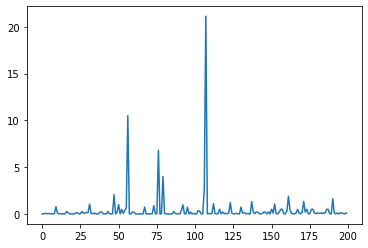

In [33]:
# ask_list[row][col] col = 0 => price, col = 1 => vol

ask_array = np.array(ask_list)
ask_env = np.abs(signal.hilbert(ask_array[:,1]))
plt.plot(ask_array[:,1])
# plt.plot(ask_env[:50])

In [ ]:
bid_array = np.array(bid_list)
plt.plot(bid_array[:,1])

In [ ]:
while True:
    board = ticker_info(SYMBOL)
    ask = board['ask']
    bid = board['bid']
    spread = (ask - bid)/bid
    mid = (ask+bid)//2
    print("-------------------")
    # print("ask",ask)
    # print("bid",bid)
    # print("spread",spread)
    print("mid",mid)
    time.sleep(2)

# 単発買い注文

In [112]:
symbol = 'BTC/JPY'
board = ticker_info(symbol)
buy_price = board['bid'] + 1
buy_price

2821928.0

In [137]:
symbol = 'BTC/JPY'
board = ticker_info(symbol)

buy_price = board['bid'] + 1
sell_price = board['ask'] - 1

order_buy = buy(buy_price)

# 単発売り注文

In [126]:
symbol = 'BTC/JPY'
board = ticker_info(symbol)

buy_price = board['bid'] + 1
sell_price = board['ask'] - 1

btc_amount = 0.005
order_sell = sell(sell_price,btc_amount=0.015)

In [162]:
balance_info()

{'info': {'success': True,
  'jpy': '9142.31471583',
  'btc': '0.015',
  'eth': '0.0',
  'etc': '0.0',
  'lsk': '0.0',
  'xrp': '0.0',
  'xem': '0.0',
  'ltc': '0.0',
  'bch': '0.0',
  'mona': '0.0',
  'xlm': '0.0',
  'qtum': '0.0',
  'bat': '0.0',
  'iost': '0.0',
  'enj': '0.0',
  'omg': '0.0',
  'plt': '0.0',
  'sand': '0.0',
  'xym': '0.0',
  'dot': '0.0',
  'jpy_reserved': '0.0',
  'btc_reserved': '0.0',
  'eth_reserved': '0.0',
  'etc_reserved': '0.0',
  'lsk_reserved': '0.0',
  'xrp_reserved': '0.0',
  'xem_reserved': '0.0',
  'ltc_reserved': '0.0',
  'bch_reserved': '0.0',
  'mona_reserved': '0.0',
  'xlm_reserved': '0.0',
  'qtum_reserved': '0.0',
  'bat_reserved': '0.0',
  'iost_reserved': '0.0',
  'enj_reserved': '0.0',
  'omg_reserved': '0.0',
  'plt_reserved': '0.0',
  'sand_reserved': '0.0',
  'xym_reserved': '0.0',
  'dot_reserved': '0.0',
  'jpy_lend_in_use': '0.0',
  'btc_lend_in_use': '0.0',
  'eth_lend_in_use': '0.0',
  'etc_lend_in_use': '0.0',
  'lsk_lend_in_use': 

In [161]:
symbol = 'BTC/JPY'
order_now = OpenOrder(symbol)

order_now


[]

# order cancel

In [160]:
order_id = order_buy['id']
order_cancel = OrderCancel(4964615603,symbol)

# 売買システム　コード

In [165]:
remain_btc = float(balance_info()['info']['btc'])
remain_btc

0.0

In [167]:



trade_count = 0
profit = 0
total_profit = 0
# スプレッドの閾値
ALPHA = 0.0004
# 指値更新の値幅, 2円ずつ更新
dp = 2
btc_amount = 0.005
remain_btc = 0

#---------------------------------
# ログの出力名の設定
logger = getLogger('LoggingTest')

#　ログレベルの設定
logger.setLevel(10)

# ログのコンソール出力の設定
# sh = StreamHandler()
# logger.addHandler(sh)

# ログのファイル出力先を設定
file_name = datetime.datetime.now().strftime('%Y%m%d') + '_' + datetime.datetime.now().strftime('%H%M%S')+'.log'
path_log = '/Users/Owner/Desktop/BitCoin/Log/'
fh = FileHandler(path_log+file_name)
logger.addHandler(fh)


# ログの出力形式の設定
formatter = logging.Formatter('%(asctime)s:%(lineno)d:%(levelname)s:%(message)s')
fh.setFormatter(formatter)
# sh.setFormatter(formatter)
#------------------------------
logger.info('Trade Start')
pos = 'none'
remain_btc = float(balance_info()['info']['btc'])

while True:
    try:
        # loop_count = 0
        
        if pos=='none':
            
            # ------------------------------
            # 指値変更
            # St_mean = return_St_mean()
            # St = return_St()
            # St_mean += St
            # St_mean /= 2
            # gamma = 1e-12
            # sigma = (St-St_mean)**2
            # delta = gamma * sigma
            #--------------------------------
            
            # if delta>=1000:
            #     delta = 1000
            
            # if delta<100:
            #     delta = 100
            
            delta = 400
                
            ask,bid,buy_price,sell_price = calc_best_price(size_thru=SIZE_THRU)
            
            spread = (ask-bid)/bid
            mid = int((ask+bid)/2)
            
            # buy_price = mid - delta
            # sell_price = mid + delta
            
            if spread >= ALPHA:
                
                # 注文数量が残った時,　前回の数量を上乗せして発注する
                if remain_btc>btc_amount:
                    sell_amount = remain_btc
                    order_sell = sell(sell_price,btc_amount=sell_amount)
                    order_buy = buy(buy_price,btc_amount=btc_amount)
                    logger.info('Over amount')
                
                # 在庫が最小取引単位を下回ったら買い増ししなけらばならない
                elif remain_btc<btc_amount:
                    logger.info('Low amount')
                    order_buy = buy(buy_price,btc_amount=btc_amount)
                    time.sleep(5)
                    order_now = OpenOrder(symbol)
                    
                    while len(order_now)!=0:
                        ask,bid,buy_price,sell_price = calc_best_price(size_thru=SIZE_THRU)
                        try:
                            order_id = order_now[0]['id']
                            order_cancel = OrderCancel(order_id,symbol)
                            time.sleep(0.2)
                        except Exception as e:
                            logger.info(e)
                            break
                        
                        order_buy = buy(buy_price,btc_amount=btc_amount)
                        time.sleep(5)
                        order_now = OpenOrder(symbol)
                
                # 正常な取引数量の時   
                elif remain_btc==btc_amount:
                    sell_amount = btc_amount
                    order_sell = sell(sell_price,btc_amount=sell_amount)
                    order_buy = buy(buy_price,btc_amount=btc_amount)
                    logger.info('remain_btc {0}'.format(remain_btc))
                
                

                pos = 'entry'
                logger.info('entry')
                time.sleep(5)
            
            
        if pos=='entry':
            # 買えたかどうかチェック
            is_buy, is_sell = get_status()
            message = str(is_buy)+'_'+str(is_sell)
            logger.info('--------status--------')
            logger.info(message)
            
            # 売買終了
            if is_buy and is_sell:
                trade_count, pos, profit, remain_btc = show_info(sell_price,buy_price,trade_count,total_profit,spread,btc_amount=btc_amount)
                total_profit += profit
                remain_btc = float(remain_btc)
            
            # 買い指値変更検討
            if not is_buy and is_sell:
                # 利ざや　1円で妥協
                buy_price_tmp = sell_price - delta
                symbol = 'BTC/JPY'
                order_now = OpenOrder(symbol)
                

                try:
                    order_id = order_now[0]['id']
                    order_cancel = OrderCancel(order_id,symbol)
                    time.sleep(1)
                    order_buy = buy(buy_price_tmp,btc_amount=btc_amount)
                    buy_price = buy_price_tmp
                    logger.info('Update buy price {0}'.format(int(buy_price)))
                    # S6かS7に遷移
                except Exception as e:
                    # ここで無理やり, is_buy の値変える？
                    logger.info(e)
                    logger.info('in Update buy')
                    trade_count, pos, profit,remain_btc = show_info(sell_price,buy_price,trade_count,total_profit,spread,btc_amount=btc_amount)
                    total_profit += profit
                    remain_btc = float(remain_btc)
                
            # 売り指値変更検討
            if is_buy and not is_sell:
                # 利ざや1円で妥協
                sell_price_tmp = buy_price + delta
                symbol = 'BTC/JPY'
                order_now = OpenOrder(symbol)
                
                
                try:
                    order_id = order_now[0]['id']
                    order_cancel = OrderCancel(order_id,symbol)
                    time.sleep(1)
                    order_sell = sell(sell_price_tmp,btc_amount=sell_amount)
                    sell_price = sell_price_tmp
                    logger.info('Update sell price {0}'.format(int(sell_price)))
                    
                except Exception as e:
                    logger.info(e)
                    logger.info('in Update sell')
                    trade_count, pos, profit,remain_btc = show_info(sell_price,buy_price,trade_count,total_profit,spread,btc_amount=btc_amount)
                    total_profit += profit
                    remain_btc = float(remain_btc)
            # 買い, 売り指値変更検討
            if not is_buy and not is_sell:
                try:
                    order_id = order_sell['id']
                    order_cancel = OrderCancel(order_id,symbol)
                    order_id = order_buy['id']
                    order_cancel = OrderCancel(order_id,symbol)
                    pos = 'none'
                    logger.info('Successfully canceled both order.')
                    b_info = balance_info()
                    remain_btc = b_info['info']['btc']
                except Exception as e:
                    logger.info(e)
                
        
        
        time.sleep(2)

    except KeyboardInterrupt:
        logger.info('Finish trade')
        break
    
    except Exception as e:
        logger.info(e)
        break





In [147]:
0.005-float(balance_info()['info']['btc'])

0.00017150999999999972

In [149]:
balance_info()['info']['btc']

'0.00482849'

In [ ]:
symbol = 'BTC/JPY'
order_now = OpenOrder(symbol)
order_now

In [ ]:
order_id = order_now[0]['id']

order_cancel = OrderCancel(order_id,symbol)
